<a href="https://colab.research.google.com/github/KellyJBelly/marketing_analytics-case3/blob/main/MarketingAnalytics_CaseStudy3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study 2 :  John Rhees, Tommy Braswell, Annabelle Cunningham, & Kelly Fisher

## Hypothesis Questions:


In [81]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
sns.set_theme(style="darkgrid")

In [82]:
# GITHUB_BASE = "https://github.com/KellyJBelly/marketing_analytics-case3"

# Raw GitHub URLs (replace with your actual raw links)
cpi_url = "https://raw.githubusercontent.com/KellyJBelly/marketing_analytics-case3/main/CPIUFDSL.csv"
diesel_url = "https://raw.githubusercontent.com/KellyJBelly/marketing_analytics-case3/main/GASDESM.csv"
expected_inflation_url = "https://raw.githubusercontent.com/KellyJBelly/marketing_analytics-case3/main/EXPINF10YR.csv"
unemployment_url = "https://raw.githubusercontent.com/KellyJBelly/marketing_analytics-case3/main/file.csv"
meat_grain_url = "https://raw.githubusercontent.com/KellyJBelly/marketing_analytics-case3/refs/heads/main/Meat_Grain.csv"
meat_url = "https://raw.githubusercontent.com/KellyJBelly/marketing_analytics-case3/refs/heads/main/Meaty.csv"
grain_url = "https://raw.githubusercontent.com/KellyJBelly/marketing_analytics-case3/refs/heads/main/Grainy.csv"
food_cpi_url = "https://raw.githubusercontent.com/KellyJBelly/marketing_analytics-case3/refs/heads/main/food_cpi_sets.csv"
cpi_specifics_url = "https://raw.githubusercontent.com/KellyJBelly/marketing_analytics-case3/refs/heads/main/bls%20cpi%20price%20data.csv"

# Load CSVs
cpi = pd.read_csv(cpi_url, parse_dates=['observation_date'])
diesel = pd.read_csv(diesel_url, parse_dates=['observation_date'])
expected_inflation = pd.read_csv(expected_inflation_url, parse_dates=['observation_date'])
unemp = pd.read_csv(unemployment_url)

# Parse unemployment date and filter columns
unemp['Month'] = unemp['Period'].str[1:].astype(int)
unemp['Date'] = pd.to_datetime(unemp['Year'].astype(str) + '-' + unemp['Month'].astype(str) + '-01')
unemp = unemp[['Date', 'Value']].rename(columns={'Value': 'Unemployment_rate'})

# Rename columns for consistency
cpi = cpi.rename(columns={'observation_date': 'Date', 'CPIUFDSL': 'CPI_food'})
diesel = diesel.rename(columns={'observation_date': 'Date', 'GASDESM': 'Diesel_price'})
expected_inflation = expected_inflation.rename(columns={'observation_date': 'Date', 'EXPINF10YR': 'Inf_Exp_10yr'})

# Merge all datasets on 'Date'
df = cpi.merge(diesel, on='Date') \
        .merge(expected_inflation, on='Date') \
        .merge(unemp, on='Date')

In [83]:
#MEAT ONLY
# meaty = pd.read_csv(meat_url)
# meaty.head()

#GRAIN ONLY
# grainy = pd.read_csv(grain_url)
# grainy.head()


#MEAT & GRAIN COMBIED
# meaty_grain = pd.read_csv(meat_grain_url)
# meaty_grain.head()

In [84]:
food_cpi = pd.read_csv(food_cpi_url)
food_cpi.head()

,Commodity,Beef,Shrimp Meal,Lamb,Pork,Poultry,Fish,Shrimp,IMF Meat (Avg),Barley,Corn,Rice,Soybeans,Wheat,IMF Grain Index (Avg)
0,Data Type,USD,USD,USD,USD,USD,USD,USD,USD,USD,USD,USD,USD,USD,USD
1,Frequency,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,monthly
2,1993M7,127.94,375.25,130.1,65.46,56.7,5.4,6.28,109.59,74.03,101.89,210,258.84,127.52,154.46
3,1993M8,127.17,388.36,129.77,68.43,57.93,5.05,6.13,111.83,69.69,100.31,210,246.64,129.8,151.29
4,1993M9,124.01,389.89,132.62,68.98,57.58,4.73,5.77,111.94,64.41,101.03,206,236.06,131.29,147.76


In [85]:
cpi_breakdown = pd.read_csv(cpi_specifics_url)
cpi_breakdown.head()
####### TO DO: set NaN values to average of column

,Month,Bananas per lb,Oranges per lb,Bread per lb,Tomatoes per lb,Chicken per lb,Eggs per doz,Gasoline per gal,Beef per lb,Milk per gal
0,Mar-05,0.507,0.783,1.002,1.548,1.061,1.132,2.065,2.519,3.226
1,Apr-05,0.503,0.816,1.004,1.710,1.070,1.164,2.283,2.504,3.225
2,May-05,0.497,0.899,1.086,1.911,1.052,1.185,2.216,2.572,3.207
3,Jun-05,0.493,1.012,1.090,1.655,1.075,1.139,2.176,2.542,3.122
4,Jul-05,0.494,NaN,1.067,1.607,1.067,1.165,2.316,2.541,3.090


In [86]:
# Display head and date range
print(df[['Date', 'CPI_food', 'Diesel_price', 'Inf_Exp_10yr', 'Unemployment_rate']].head(3))
print("Date range:", df['Date'].min(), "to", df['Date'].max())

        Date  CPI_food  Diesel_price  Inf_Exp_10yr  Unemployment_rate
0 2000-01-01     165.6         1.356      3.274370                4.0
1 2000-02-01     166.2         1.461      3.348824                4.1
2 2000-03-01     166.5         1.479      3.328662                4.0
Date range: 2000-01-01 00:00:00 to 2025-03-01 00:00:00


## Exploratory Data Analysis & Data Transformation

       Food_Percentage_Change  Diesel_Percent_Change  InfExp_pct_chg
count              302.000000             302.000000      302.000000
mean                 0.236539               0.445816        0.040832
std                  0.253868               4.984253        5.594547
min                 -0.378775             -19.574944      -21.570582
25%                  0.088566              -1.928414       -3.259360
50%                  0.188615               0.319238        0.128357
75%                  0.344206               3.366672        3.237801
max                  1.427146              26.612103       17.614506


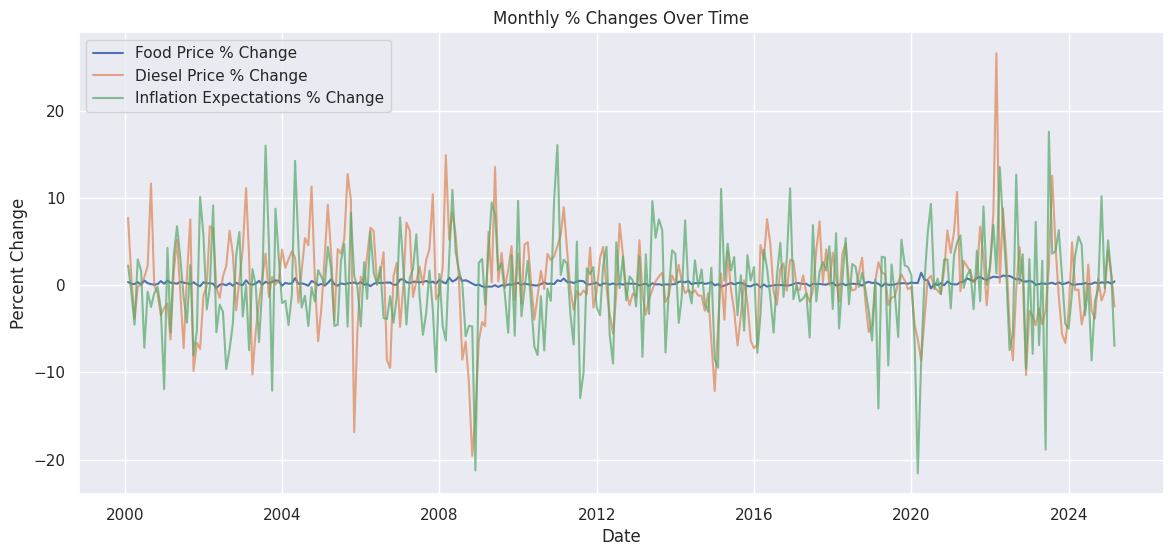

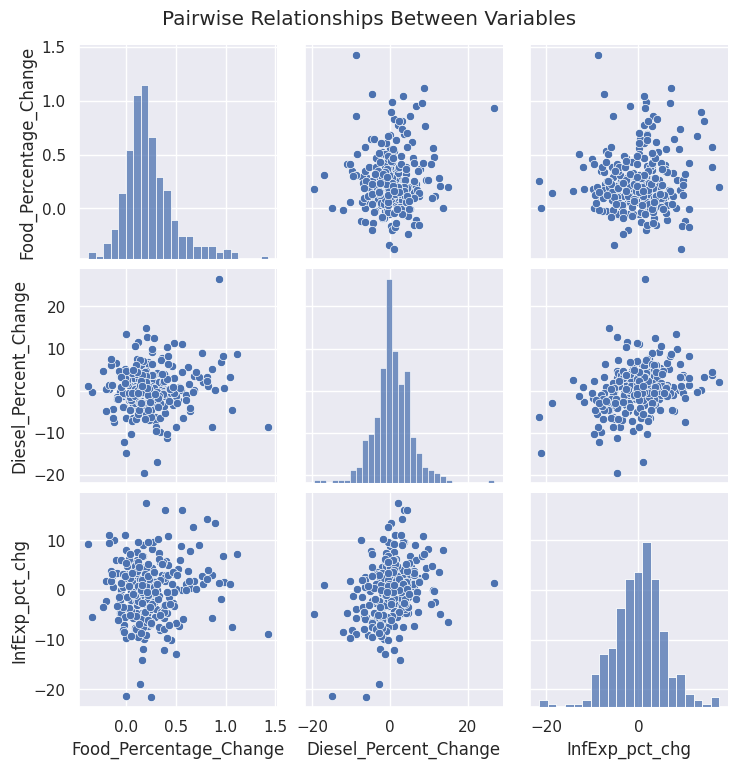

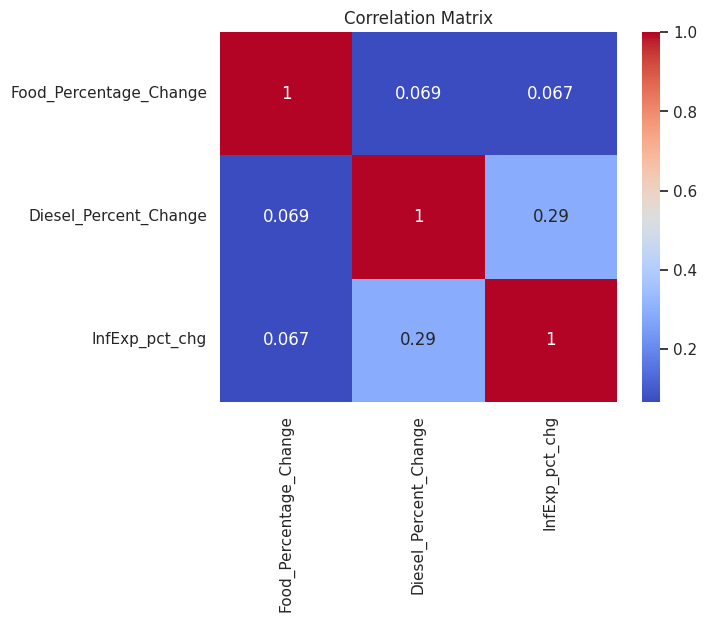

In [87]:
# Sort by date and compute % changes
df = df.sort_values('Date')
df['Food_Percentage_Change']   = df['CPI_food'].pct_change() * 100
df['Diesel_Percent_Change'] = df['Diesel_price'].pct_change() * 100
df['InfExp_pct_chg'] = df['Inf_Exp_10yr'].pct_change() * 100
df.dropna(inplace=True)

# Summary statistics
print(df[['Food_Percentage_Change', 'Diesel_Percent_Change', 'InfExp_pct_chg']].describe())

# Time series plots
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Food_Percentage_Change'], label='Food Price % Change')
plt.plot(df['Date'], df['Diesel_Percent_Change'], label='Diesel Price % Change', alpha=0.7)
plt.plot(df['Date'], df['InfExp_pct_chg'], label='Inflation Expectations % Change', alpha=0.7)
plt.legend()
plt.title('Monthly % Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.grid(True)
plt.show()

# Pairplot for correlation visualization
sns.pairplot(df[['Food_Percentage_Change', 'Diesel_Percent_Change', 'InfExp_pct_chg']])
plt.suptitle("Pairwise Relationships Between Variables", y=1.02)
plt.show()

# Correlation matrix heatmap
corr = df[['Food_Percentage_Change', 'Diesel_Percent_Change', 'InfExp_pct_chg']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## OLS Regression: Food % Change ~ Diesel % Change + Inflation Expectation % Change

In [88]:
import statsmodels.api as sm

# Prepare data for regression
X = df[['Diesel_Percent_Change', 'InfExp_pct_chg']]
X = sm.add_constant(X)  # add constant term
y = df['Food_Percentage_Change']

# Fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

#Augmented Dickey Fuller Stationarity Test
residuals = model.resid
adf_result = adfuller(residuals)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


                              OLS Regression Results                              
Dep. Variable:     Food_Percentage_Change   R-squared:                       0.007
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                     1.071
Date:                    Thu, 24 Apr 2025   Prob (F-statistic):              0.344
Time:                            06:18:25   Log-Likelihood:                -12.916
No. Observations:                     302   AIC:                             31.83
Df Residuals:                         299   BIC:                             42.96
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

## Casual Delay Affect

This is relative to real world economic systems, causal effects often occur with a time lag rather than instantaneously. For example, when diesel prices increase, transportation and logistics costs for food suppliers go up — but it may take weeks or months for those costs to be reflected in retail grocery prices due to existing inventory, supply contracts, and pricing cycles. This delay is known as a causal delay effect, and it's crucial in time series modeling because ignoring it can lead to underestimating true relationships between variables. Including lagged variables helps capture these delayed pass-through effects and improves both explanatory power and forecast accuracy.

In [89]:
# add lags to show impact of time lag as it is relative to real world
df['Diesel_Percent_Change_lag1'] = df['Diesel_Percent_Change'].shift(1)
df['InfExp_pct_chg_lag1'] = df['InfExp_pct_chg'].shift(1)

# OLS regression with lags
X_lagged = sm.add_constant(df[['Diesel_Percent_Change', 'Diesel_Percent_Change_lag1',
                               'InfExp_pct_chg', 'InfExp_pct_chg_lag1']].dropna())
y_lagged = df['Food_Percentage_Change'].loc[X_lagged.index]

model_lag = sm.OLS(y_lagged, X_lagged).fit()
print(model_lag.summary())

                              OLS Regression Results                              
Dep. Variable:     Food_Percentage_Change   R-squared:                       0.017
Model:                                OLS   Adj. R-squared:                  0.004
Method:                     Least Squares   F-statistic:                     1.275
Date:                    Thu, 24 Apr 2025   Prob (F-statistic):              0.280
Time:                            06:18:25   Log-Likelihood:                -11.752
No. Observations:                     301   AIC:                             33.50
Df Residuals:                         296   BIC:                             52.04
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

#Feedback Loops Created by Diesel Pricing Vector Auto-Regression

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 24, Apr, 2025
Time:                     06:18:25
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.69615
Nobs:                     298.000    HQIC:                   3.40598
Log likelihood:          -1708.16    FPE:                    24.8403
AIC:                      3.21230    Det(Omega_mle):         21.8537
--------------------------------------------------------------------
Results for equation Food_Percentage_Change
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.059904         0.017214            3.480           0.001
L1.Food_Percentage_Change         0.321003         0.058770            5.462           0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


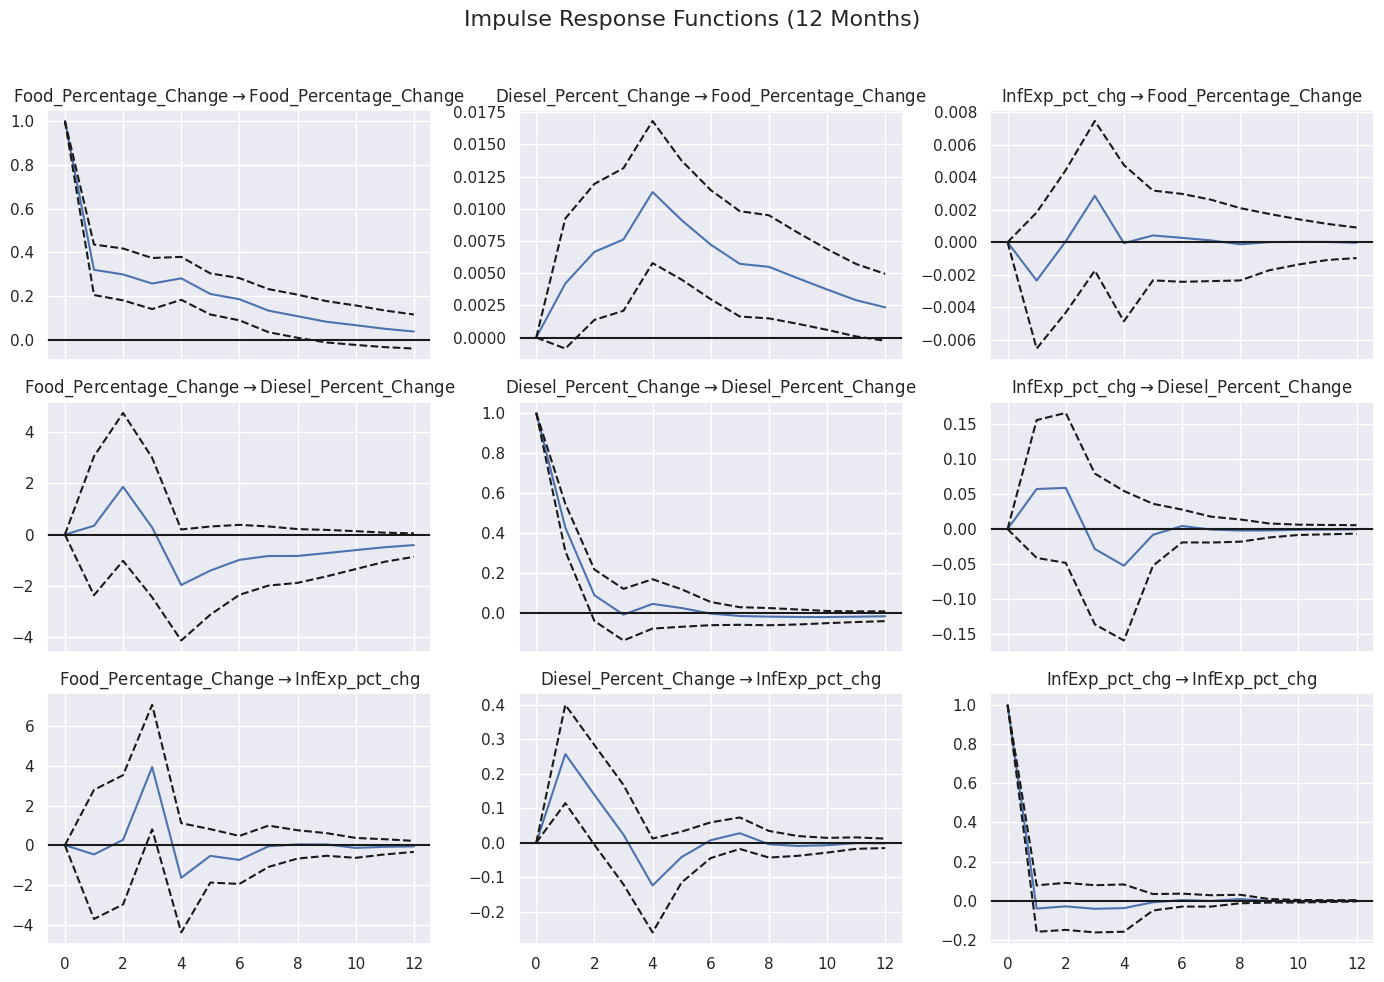

In [90]:
var_data = df[['Food_Percentage_Change', 'Diesel_Percent_Change', 'InfExp_pct_chg']].dropna()

# Fit VAR model with lag selection based on AIC
model_var = VAR(var_data)
results_var = model_var.fit(maxlags=4, ic='aic')
print(results_var.summary())

# Test if Diesel or Inflation expectations Granger-cause food price changes
print("Granger Causality Test (Diesel → Food):")
grangercausalitytests(var_data[['Food_Percentage_Change', 'Diesel_Percent_Change']], maxlag=4)

print("\nGranger Causality Test (Inflation Expectation → Food):")
grangercausalitytests(var_data[['Food_Percentage_Change', 'InfExp_pct_chg']], maxlag=4)

def plot_granger_pvalues(df, cause, effect, maxlag=8):
    """
    Plot Granger causality p-values across lags.

    cause: str - the variable that may cause
    effect: str - the variable being explained
    """
    p_values = []
    for lag in range(1, maxlag+1):
        test_result = grangercausalitytests(df[[effect, cause]], maxlag=lag, verbose=False)
        p_val = test_result[lag][0]['ssr_ftest'][1]  # get p-value from F-test
        p_values.append(p_val)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, maxlag+1), p_values, marker='o', linestyle='-')
    plt.axhline(y=0.05, color='red', linestyle='--', label='0.05 Significance Threshold')
    plt.title(f'Granger Causality P-Values\nDoes {cause} → {effect}?')
    plt.xlabel('Lag')
    plt.ylabel('P-Value')
    plt.xticks(range(1, maxlag+1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Impulse Response Plot (12-period horizon)
irf = results_var.irf(12)

# Fix overlapping text with larger figure and better layout
fig = irf.plot(orth=False, figsize=(14, 10))
fig.suptitle("Impulse Response Functions (12 Months)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # reserve space for title
plt.show()


## Consumer Price Index Food VAR

In [91]:
# import pandas as pd
# from statsmodels.tsa.api import VAR
# import matplotlib.pyplot as plt

# # STEP 1: Load the actual data (skip the first 2 rows: metadata)
# food_prices = pd.read_csv(food_cpi_url, skiprows=2)
# # Drop non-data columns that came from metadata rows
# # drop_cols = [col for col in food_prices.columns if 'Unnamed' in col or 'USD' in col or 'monthly' in col or 'Avg' in col]
# # food_prices.drop(columns=drop_cols, inplace=True)

# # (Optional) Print what was removed
# print("Dropped columns:", drop_cols)


# # STEP 2: Rename the 'Frequency' column to 'Period' and convert to datetime
# food_prices.rename(columns={'Frequency': 'Period'}, inplace=True)

# # Convert 'Period' like '1993M7' to datetime
# def convert_period(period_str):
#     year = int(period_str[:4])
#     month = int(period_str[5:])
#     return pd.to_datetime(f"{year}-{month:02d}-01")

# food_prices['Date'] = food_prices['Period'].apply(convert_period)

# # STEP 3: Drop the metadata columns like 'Data Type' or 'USD' if present
# food_prices = food_prices[~food_prices['Date'].isna()]  # remove metadata rows
# food_prices.drop(columns=['Period'], inplace=True)

# # STEP 4: Set datetime as index and sort
# food_prices.set_index('Date', inplace=True)
# food_prices.sort_index(inplace=True)

# # STEP 5: Merge with macroeconomic dataframe
# df['Date'] = pd.to_datetime(df['Date'])
# merged_df = food_prices.merge(df, on='Date', how='inner')

# #STEP 6: Compute percent change and clean NaNs/Infs
# import numpy as np

# # Only use numeric columns (drop any non-numeric metadata like 'Date')
# merged_pct_df = merged_df.select_dtypes(include='number').pct_change() * 100

# # Clean out inf and NaN values
# merged_pct_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# merged_pct_df.dropna(inplace=True)

# # check if cleaning worked
# # print("NaNs left:", merged_pct_df.isna().sum().sum())
# # print("Infs left:", np.isinf(merged_pct_df.values).sum())

# # STEP 7: Fit VAR model
# model = VAR(merged_pct_df)
# results = model.fit(maxlags=4, ic='aic')
# # print(results.summary())


# # STEP 8: Plot Impulse Response Functions (IRFs)
# irf = results.irf(12)
# # Larger figure with more room for multiple subplots
# fig = irf.plot(orth=False, figsize=(24, 18))
# # Bigger, bold title
# fig.suptitle("Impulse Response Functions from VAR Model (12-Month Horizon)", fontsize=20, weight='bold')
# # Adjust layout: more margin space for top title and tighter subplot spacing
# plt.tight_layout(rect=[0, 0, 1, 0.94])
# # Show the plot
# plt.show()

# # irf = results.irf(12)
# # fig = irf.plot(orth=False, figsize=(18, 12))
# # fig.suptitle("Impulse Response Functions (VAR Model)", fontsize=13)
# # plt.tight_layout(rect=[0, 0, 1, 0.96])
# # plt.show()


In [92]:

# # === Correlation Heatmap =====
# plt.figure(figsize=(12, 8))
# sns.heatmap(merged_pct_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Matrix of % Changes", fontsize=14)
# plt.show()

# # === Time Series Preview of Key Variables ===
# plt.figure(figsize=(14, 6))
# for col in ['Beef', 'Corn', 'Diesel_price']:  # modify this list based on what we want to show
#     if col in merged_pct_df.columns:
#         plt.plot(merged_pct_df.index, merged_pct_df[col], label=col)
# plt.legend()
# plt.title("Selected % Changes Over Time")
# plt.xlabel("Date")
# plt.ylabel("Percent Change")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [93]:
# # === Forecast Plot (next 12 periods) ===
# forecast = results.forecast(merged_pct_df.values[-results.k_ar:], steps=12)
# forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=merged_pct_df.index[-1], periods=12, freq='MS'),
#                            columns=merged_pct_df.columns)

# # Plot forecast for a few key variables
# plt.figure(figsize=(14, 6))
# for col in ['Beef', 'Corn', 'Diesel_price']:  # modify this list
#     if col in forecast_df.columns:
#         plt.plot(forecast_df.index, forecast_df[col], label=f'Forecast: {col}')
# plt.legend()
# plt.title("12-Month VAR Forecast")
# plt.xlabel("Date")
# plt.ylabel("Forecasted % Change")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Forecasted Consumer Price Index ARIMA

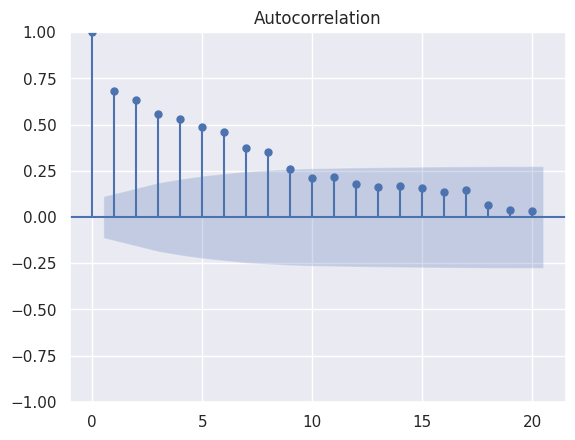

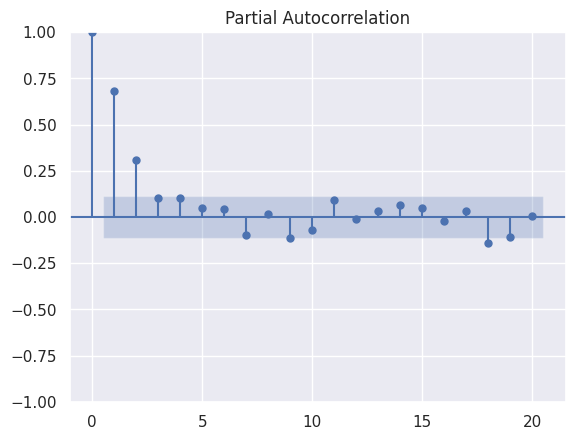

                               SARIMAX Results                                
Dep. Variable:               CPI_food   No. Observations:                  241
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -105.073
Date:                Thu, 24 Apr 2025   AIC                            216.145
Time:                        06:18:27   BIC                            226.587
Sample:                    02-01-2000   HQIC                           220.353
                         - 02-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9570      0.020     47.078      0.000       0.917       0.997
ma.L1         -0.6147      0.058    -10.663      0.000      -0.728      -0.502
sigma2         0.1398      0.011     12.358      0.0

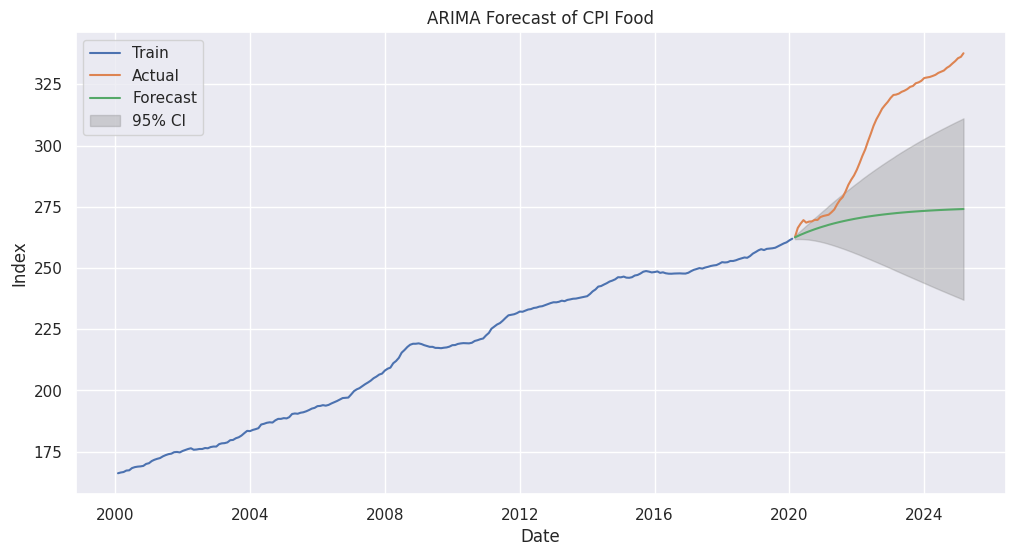

In [94]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math
import numpy as np

ts = df[['Date', 'CPI_food']].dropna().copy()
ts.set_index('Date', inplace=True)
ts = ts.asfreq('MS')  # Ensure monthly frequency

# --- Plot ACF/PACF if you want to eyeball p/q ---
plot_acf(ts['CPI_food'].diff().dropna(), lags=20)
plot_pacf(ts['CPI_food'].diff().dropna(), lags=20)
plt.show()

# --- Split into train/test (80/20 split) ---
split = int(len(ts) * 0.8)
train, test = ts.iloc[:split], ts.iloc[split:]

# --- Fit ARIMA model ---
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

# --- Forecast on test set ---
forecast_result = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# --- Evaluate Forecast ---
mse = mean_squared_error(test, forecast_mean)
mae = mean_absolute_error(test, forecast_mean)
mape = mean_absolute_percentage_error(test, forecast_mean) * 100

print(f"ARIMA Forecast RMSE: {math.sqrt(mse):.2f}")
print(f"MAE: {mae:.2f} | MAPE: {mape:.2f}%")


plt.figure(figsize=(12,6))
plt.plot(train.index, train['CPI_food'], label='Train')
plt.plot(test.index, test['CPI_food'], label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast')
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='gray', alpha=0.3, label='95% CI')
plt.title("ARIMA Forecast of CPI Food")
plt.xlabel("Date")
plt.ylabel("Index")
plt.legend()
plt.grid(True)
plt.show()


## Price Sensitivity from Economic Events (COVID, 2008 Financial Crisis)

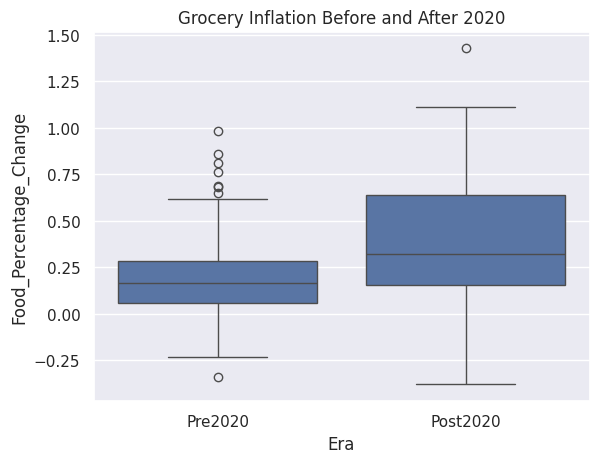

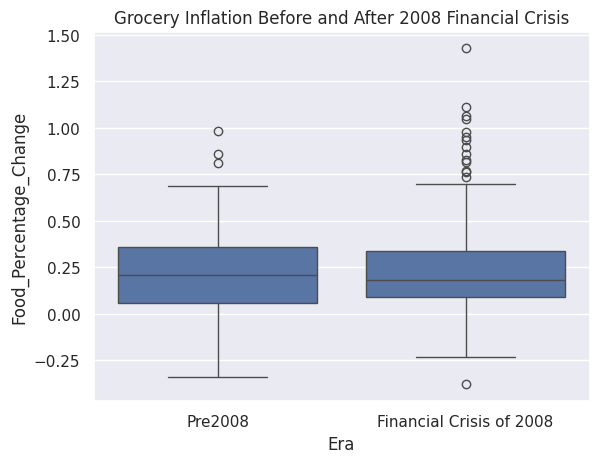

In [95]:
df['Era'] = df['Date'].apply(lambda x: 'Post2020' if x >= pd.to_datetime("2020-01-01") else 'Pre2020')
sns.boxplot(x='Era', y='Food_Percentage_Change', data=df)
plt.title("Grocery Inflation Before and After 2020")
plt.show()


df['Era'] = df['Date'].apply(lambda x: 'Financial Crisis of 2008' if x >= pd.to_datetime("2010-07-01") else 'Pre2008')
sns.boxplot(x='Era', y='Food_Percentage_Change', data=df)
plt.title("Grocery Inflation Before and After 2008 Financial Crisis")
plt.show()

## MyPlate

In [96]:
cpi_specifics_url = "https://raw.githubusercontent.com/KellyJBelly/marketing_analytics-case3/refs/heads/main/bls%20cpi%20price%20data.csv"

cpi_breakdown = pd.read_csv(cpi_specifics_url)
cpi_breakdown.head()


,Month,Bananas per lb,Oranges per lb,Bread per lb,Tomatoes per lb,Chicken per lb,Eggs per doz,Gasoline per gal,Beef per lb,Milk per gal
0,Mar-05,0.507,0.783,1.002,1.548,1.061,1.132,2.065,2.519,3.226
1,Apr-05,0.503,0.816,1.004,1.710,1.070,1.164,2.283,2.504,3.225
2,May-05,0.497,0.899,1.086,1.911,1.052,1.185,2.216,2.572,3.207
3,Jun-05,0.493,1.012,1.090,1.655,1.075,1.139,2.176,2.542,3.122
4,Jul-05,0.494,NaN,1.067,1.607,1.067,1.165,2.316,2.541,3.090


In [97]:
cpi_breakdown = cpi_breakdown.fillna(method='ffill')

# MyPlate category columns as the average of relevant foods
cpi_breakdown['Fruits'] = cpi_breakdown[['Bananas per lb', 'Oranges per lb']].mean(axis=1)
cpi_breakdown['Vegetables'] = cpi_breakdown['Tomatoes per lb']
cpi_breakdown['Grains'] = cpi_breakdown['Bread per lb']
cpi_breakdown['Protein'] = cpi_breakdown[['Chicken per lb', 'Eggs per doz', 'Beef per lb']].mean(axis=1)
cpi_breakdown['Dairy'] = cpi_breakdown['Milk per gal']

cpi_breakdown['Plate_Cost'] = (
    cpi_breakdown['Fruits'] +
    cpi_breakdown['Vegetables'] +
    cpi_breakdown['Grains'] +
    cpi_breakdown['Protein'] +
    cpi_breakdown['Dairy']
)


<ipython-input-97-7a23699c5b61>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cpi_breakdown = cpi_breakdown.fillna(method='ffill')


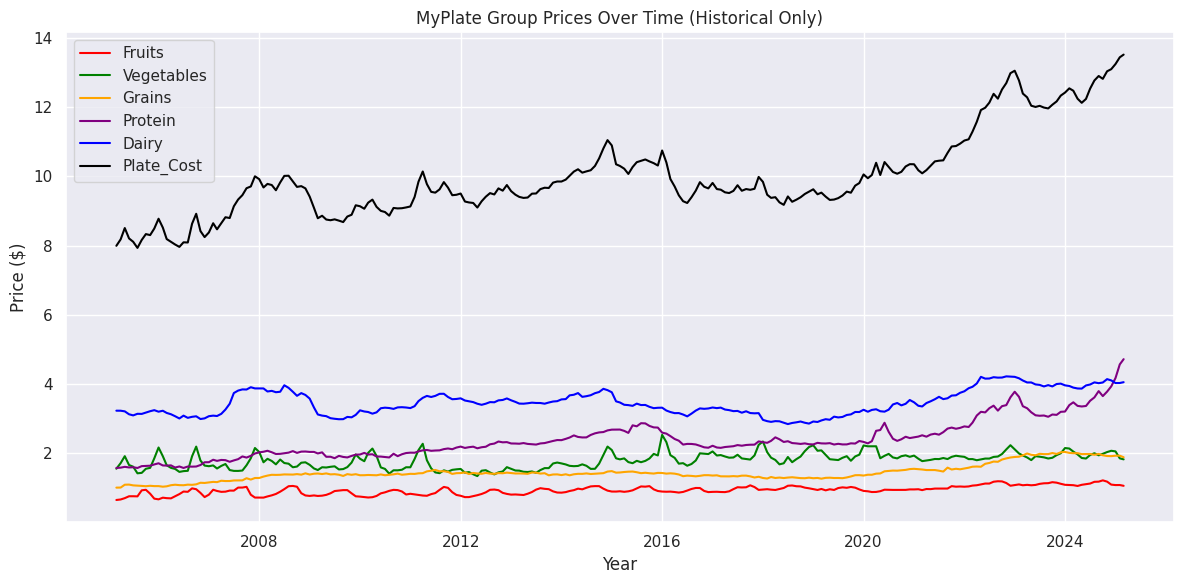

In [98]:
import matplotlib.dates as mdates

# Convert Month and set index
cpi_breakdown['Month'] = pd.to_datetime(cpi_breakdown['Month'], format='%b-%y')
myplate_df = cpi_breakdown.set_index('Month')[['Fruits', 'Vegetables', 'Grains', 'Protein', 'Dairy', 'Plate_Cost']]

# MyPlate group colors
group_colors = {
    'Fruits': 'red',
    'Vegetables': 'green',
    'Grains': 'orange',
    'Protein': 'purple',
    'Dairy': 'blue',
    'Plate_Cost': 'black'
}

# Plot with year ticks every 4 years
plt.figure(figsize=(12, 6))
for col in group_colors:
    plt.plot(myplate_df.index, myplate_df[col], label=col, color=group_colors[col])

# Set x-axis to show ticks every 4 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('MyPlate Group Prices Over Time (Historical Only)')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


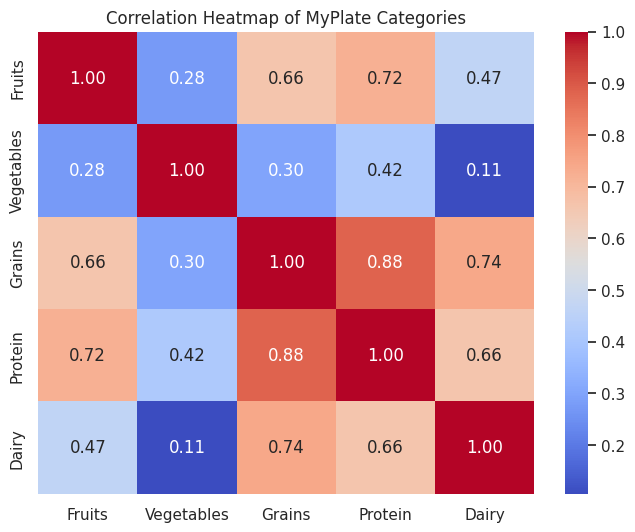

In [99]:
# Correlation matrix of MyPlate categories
plt.figure(figsize=(8, 6))
sns.heatmap(cpi_breakdown[['Fruits', 'Vegetables', 'Grains', 'Protein', 'Dairy']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of MyPlate Categories')
plt.show()

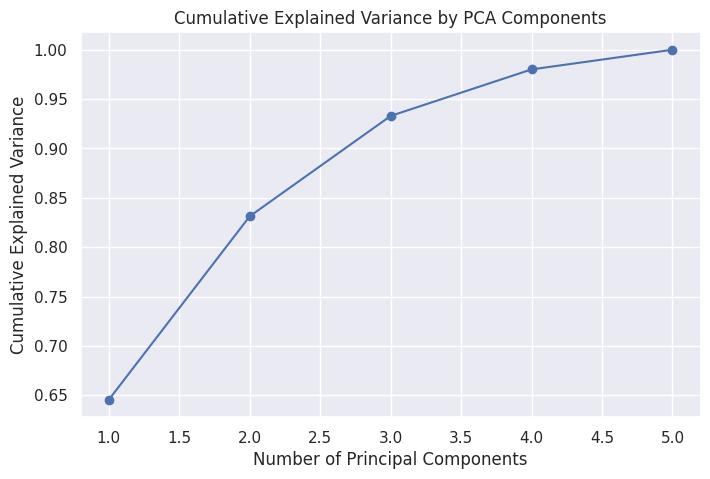

In [100]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select only the MyPlate columns
X = cpi_breakdown[['Fruits', 'Vegetables', 'Grains', 'Protein', 'Dairy']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [101]:
# Convert and set datetime index
cpi_breakdown['Month'] = pd.to_datetime(cpi_breakdown['Month'], format='%b-%y')
myplate_df = cpi_breakdown[['Fruits', 'Vegetables', 'Grains', 'Protein', 'Dairy']]
myplate_df.index = cpi_breakdown['Month']

# ADF Test: check for stationarity
print("Augmented Dickey-Fuller Test Results:\n")
for col in myplate_df.columns:
    result = adfuller(myplate_df[col])
    p_val = result[1]
    is_stationary = "Stationary ✅" if p_val < 0.05 else "Not stationary ❌"
    print(f"{col:<12} p-value: {p_val:.3f} → {is_stationary}")

# If not stationary, difference the data
myplate_diff = myplate_df.diff().dropna()

Augmented Dickey-Fuller Test Results:

Fruits       p-value: 0.625 → Not stationary ❌
Vegetables   p-value: 0.550 → Not stationary ❌
Grains       p-value: 0.407 → Not stationary ❌
Protein      p-value: 0.998 → Not stationary ❌
Dairy        p-value: 0.450 → Not stationary ❌


In [102]:
# Fit VAR model to differenced data
model = VAR(myplate_diff)

# Automatically choose lag using criteria (maxlags=12 for monthly data)
lag_selection = model.select_order(maxlags=12)

# Print results
print("Optimal Lag Selection:")
print(lag_selection.summary())

optimal_lag = lag_selection.aic  # or .bic or .hqic
print(optimal_lag)

Optimal Lag Selection:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -28.31     -28.23*   5.085e-13      -28.28
1       -28.57      -28.12   3.918e-13     -28.39*
2       -28.55      -27.73   3.976e-13      -28.22
3      -28.65*      -27.44  3.621e-13*      -28.16
4       -28.60      -27.02   3.823e-13      -27.96
5       -28.60      -26.65   3.810e-13      -27.81
6       -28.57      -26.24   3.954e-13      -27.63
7       -28.50      -25.79   4.244e-13      -27.41
8       -28.53      -25.44   4.161e-13      -27.28
9       -28.60      -25.14   3.907e-13      -27.20
10      -28.58      -24.74   4.032e-13      -27.03
11      -28.52      -24.31   4.332e-13      -26.82
12      -28.59      -24.00   4.099e-13      -26.74
--------------------------------------------------
3


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [103]:
myplate_df = cpi_breakdown[['Fruits', 'Vegetables', 'Grains', 'Protein', 'Dairy']]
myplate_df.index = pd.to_datetime(cpi_breakdown['Month'])


In [104]:
# Check if each column is stationary
for col in myplate_df.columns:
    result = adfuller(myplate_df[col])
    print(f"{col} p-value: {result[1]}")
myplate_diff = myplate_df.diff().dropna()

Fruits p-value: 0.6252820288958693
Vegetables p-value: 0.5496318776357955
Grains p-value: 0.4073546919107168
Protein p-value: 0.9984252141511274
Dairy p-value: 0.4498416995355382


In [105]:
model = VAR(myplate_diff)
results = model.fit(maxlags=12, ic='aic')  # Use AIC to choose optimal lag
print(results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 24, Apr, 2025
Time:                     06:18:29
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -27.4774
Nobs:                     237.000    HQIC:                  -28.1762
Log likelihood:           1793.36    FPE:                3.62024e-13
AIC:                     -28.6481    Det(Omega_mle):     2.61142e-13
--------------------------------------------------------------------
Results for equation Fruits
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.000965         0.002817            0.342           0.732
L1.Fruits             0.302088         0.064603            4.676           0.000
L1.Vegetables        -0.079311         0.022033           -

In [106]:
forecast_diff = results.forecast(myplate_diff.values[-results.k_ar:], steps=24)

# Convert forecast_diff (differences) to forecasted levels
forecast_index = pd.date_range(start=myplate_df.index[-1] + pd.offsets.MonthBegin(1), periods=24, freq='MS')
forecast_df = pd.DataFrame(forecast_diff, index=forecast_index, columns=myplate_df.columns)

# Add the last known value to reconstruct levels
last_values = myplate_df.iloc[-1]
forecast_cumsum = forecast_df.cumsum()
forecast_levels = forecast_cumsum.add(last_values)

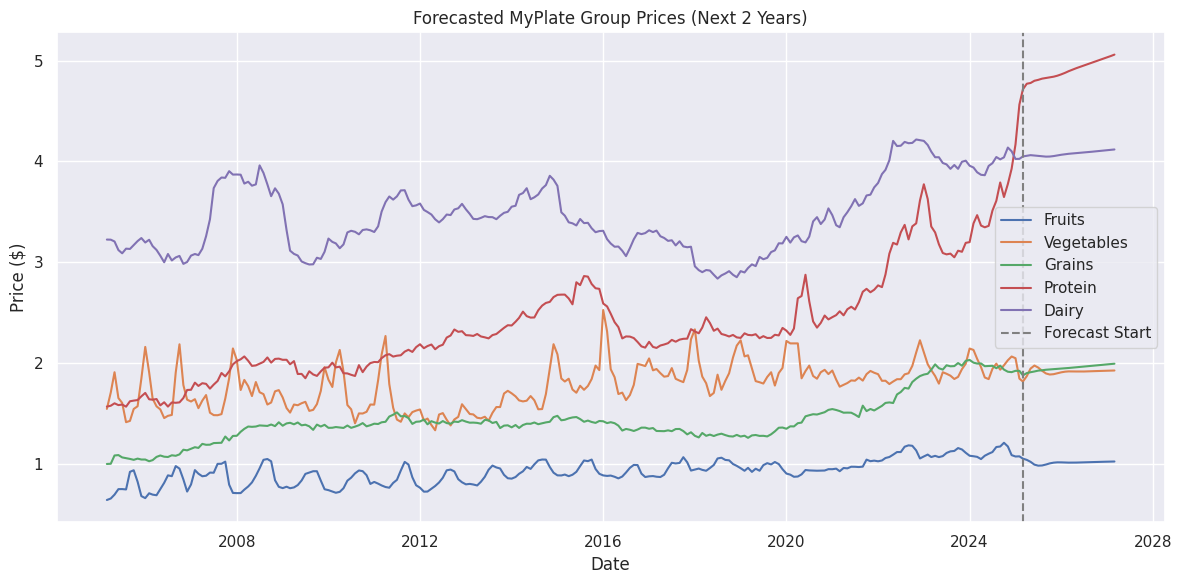

In [107]:
# Combine for plotting
full_df = pd.concat([myplate_df, forecast_levels])

# Plot each food group
plt.figure(figsize=(12, 6))
for col in myplate_df.columns:
    plt.plot(full_df.index, full_df[col], label=col)

# Highlight forecast period
plt.axvline(x=myplate_df.index[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title('Forecasted MyPlate Group Prices (Next 2 Years)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

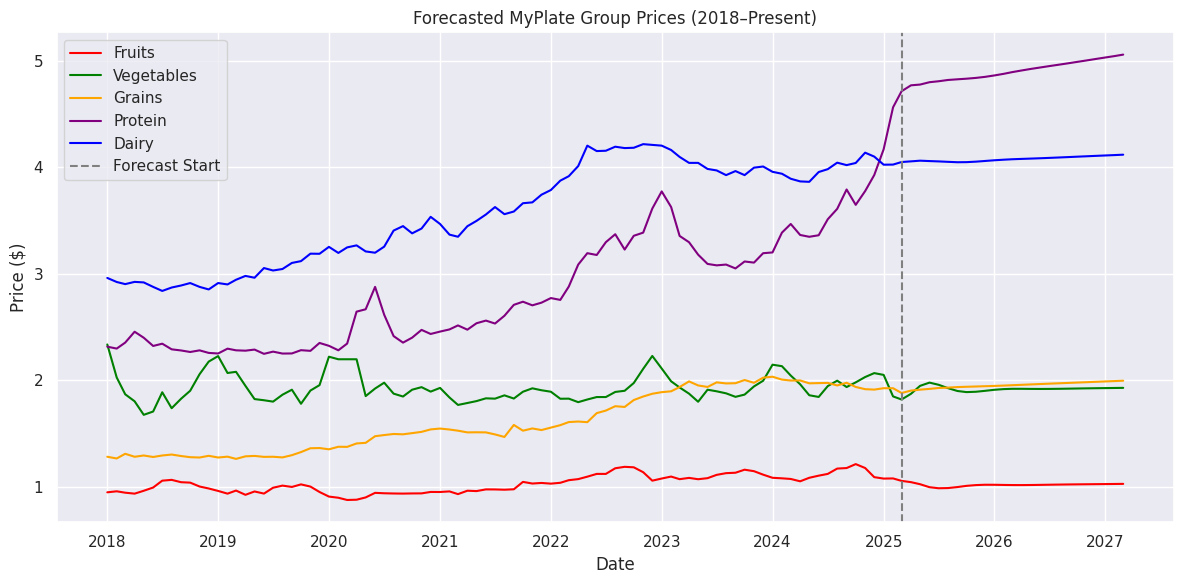

In [108]:
# Combine for plotting
full_df = pd.concat([myplate_df, forecast_levels])

# Filter to 2018 and later
full_df_filtered = full_df[full_df.index >= '2018-01-01']

# MyPlate color scheme
group_colors = {
    'Fruits': 'red',
    'Vegetables': 'green',
    'Grains': 'orange',
    'Protein': 'purple',
    'Dairy': 'blue'
}

# Plot each food group using MyPlate colors
plt.figure(figsize=(12, 6))
for col in group_colors:
    plt.plot(full_df_filtered.index, full_df_filtered[col], label=col, color=group_colors[col])

# Highlight forecast start if it's in the visible window
forecast_start = myplate_df.index[-1]
if forecast_start >= pd.to_datetime('2018-01-01'):
    plt.axvline(x=forecast_start, color='gray', linestyle='--', label='Forecast Start')

plt.title('Forecasted MyPlate Group Prices (2018–Present)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-109-20f9fca55ae5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myplate_df['Plate_Cost'] = myplate_df.sum(axis=1)


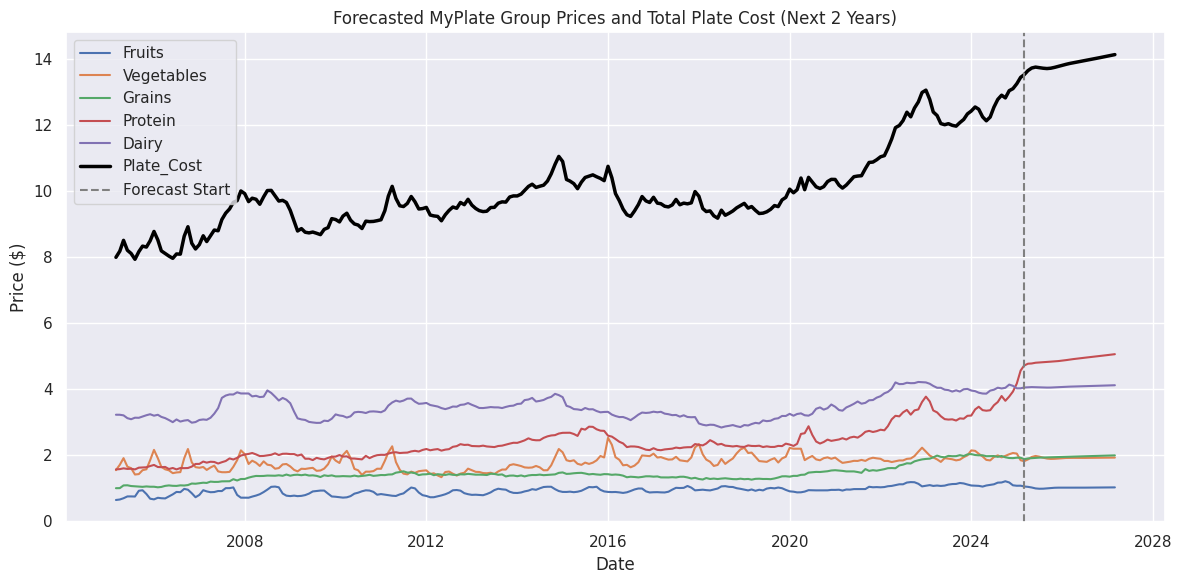

In [109]:
# Add Plate_Cost to both the forecast and original data
forecast_levels['Plate_Cost'] = forecast_levels.sum(axis=1)
myplate_df['Plate_Cost'] = myplate_df.sum(axis=1)

# Combine full dataset
full_df = pd.concat([myplate_df, forecast_levels])

plt.figure(figsize=(12, 6))

# Plot each food group
for col in ['Fruits', 'Vegetables', 'Grains', 'Protein', 'Dairy']:
    plt.plot(full_df.index, full_df[col], label=col)

# Plot Plate_Cost with thicker line
plt.plot(full_df.index, full_df['Plate_Cost'], label='Plate_Cost', color='black', linewidth=2.5)

# Mark forecast start
plt.axvline(x=myplate_df.index[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title('Forecasted MyPlate Group Prices and Total Plate Cost (Next 2 Years)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

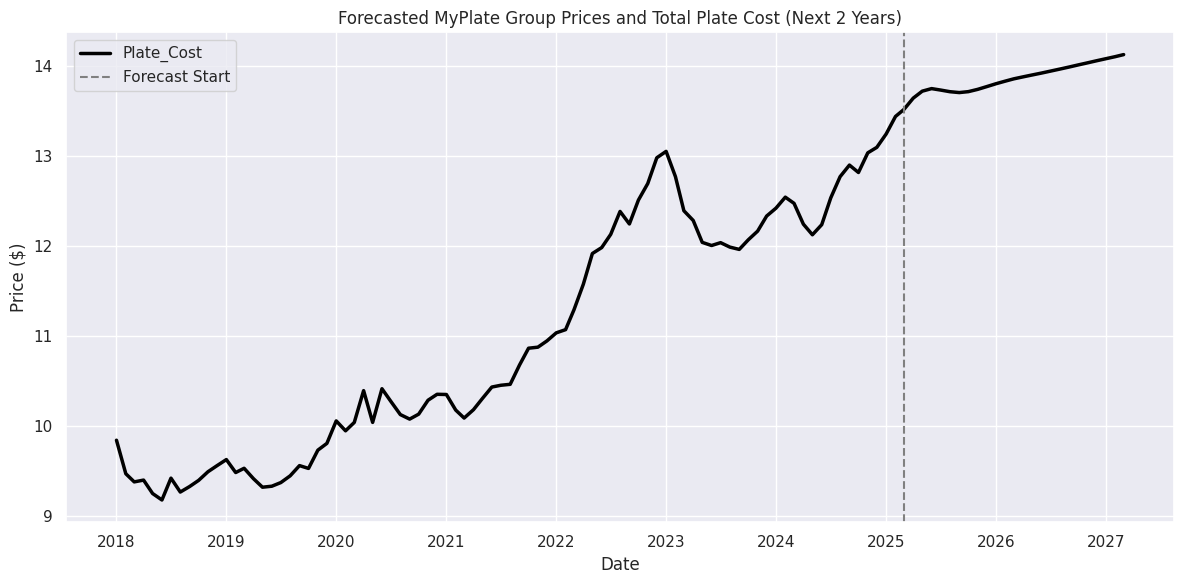

📊 Quarterly Forecast of Plate_Cost:

            Plate_Cost ($)
Date                      
2025-04-01           13.64
2025-07-01           13.73
2025-10-01           13.72
2026-01-01           13.80
2026-04-01           13.88
2026-07-01           13.94
2026-10-01           14.01
2027-01-01           14.08


In [110]:
# Filter to 2018 and later
plt.figure(figsize=(12, 6))
full_df_filtered = full_df[full_df.index >= '2018-01-01']


# Plot Plate_Cost with thicker line
plt.plot(full_df_filtered.index, full_df_filtered['Plate_Cost'], label='Plate_Cost', color='black', linewidth=2.5)

# Mark forecast start
plt.axvline(x=myplate_df.index[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title('Forecasted MyPlate Group Prices and Total Plate Cost (Next 2 Years)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate Plate_Cost as sum of the 5 MyPlate groups
forecast_levels['Plate_Cost'] = forecast_levels[['Fruits', 'Vegetables', 'Grains', 'Protein', 'Dairy']].sum(axis=1)

# Select every 3rd row for quarterly reporting
plate_cost_quarterly = forecast_levels['Plate_Cost'].iloc[::3].copy()

# Format as a nice table
plate_cost_quarterly = plate_cost_quarterly.round(2).to_frame()
plate_cost_quarterly.index.name = 'Date'
plate_cost_quarterly.columns = ['Plate_Cost ($)']

# Display the table
print("📊 Quarterly Forecast of Plate_Cost:\n")
print(plate_cost_quarterly)


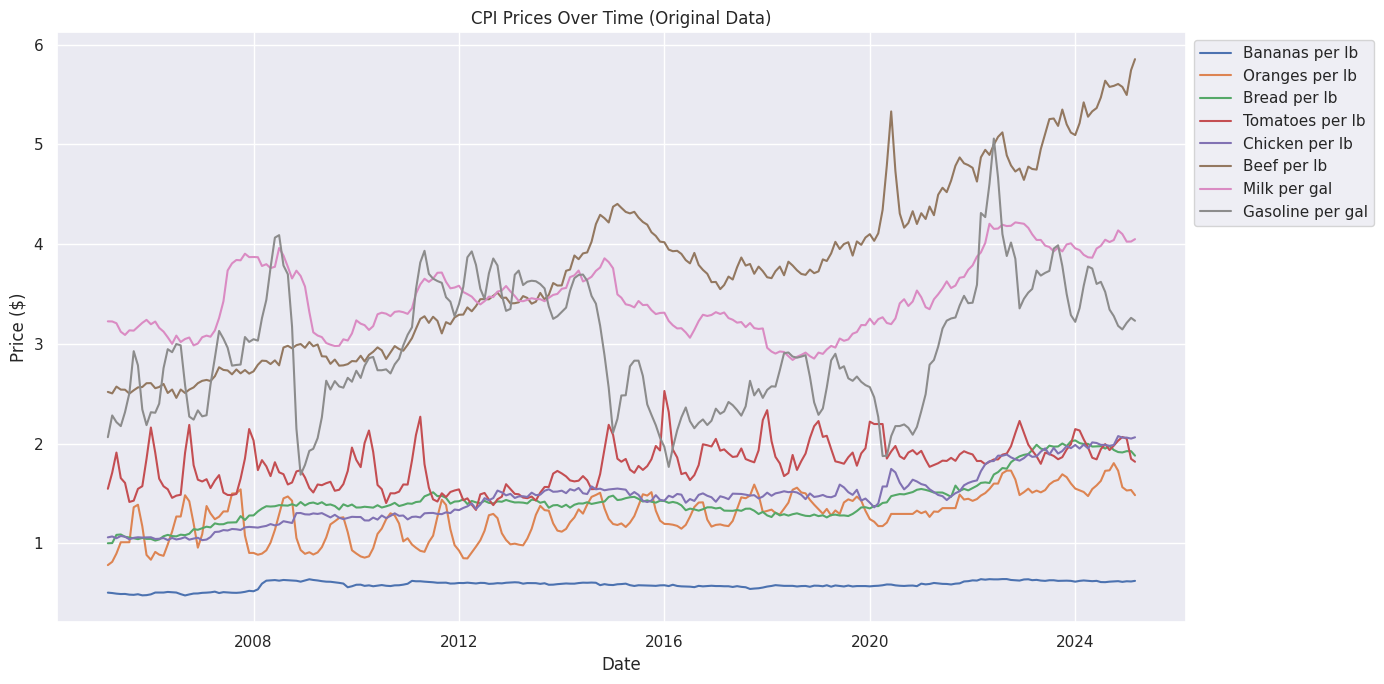

In [111]:
# Convert 'Month' to datetime if it's not already
cpi_breakdown['Month'] = pd.to_datetime(cpi_breakdown['Month'], format='%b-%y')

# Set 'Month' as the index
cpi_breakdown.set_index('Month', inplace=True)

# Select only the original CPI columns (adjust this list based on your dataset)
original_columns = [
    'Bananas per lb', 'Oranges per lb', 'Bread per lb', 'Tomatoes per lb',
    'Chicken per lb', 'Eggs per doz.', 'Beef per lb', 'Milk per gal', 'Gasoline per gal'
]

# Create line plot
plt.figure(figsize=(14, 7))
for col in original_columns:
    if col in cpi_breakdown.columns:
        plt.plot(cpi_breakdown.index, cpi_breakdown[col], label=col)

plt.title('CPI Prices Over Time (Original Data)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()